In [114]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np
from numpy import linalg as LA

from matplotlib import pyplot as plt

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod
from art.attacks.evasion import ProjectedGradientDescent
from art.utils import to_categorical

In [115]:
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires Tensorflow v2.')

In [116]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_test = x_test[0:100]
y_test = y_test[0:100]

# Train and evaluate a baseline classifier

In [117]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']);

In [118]:
model.fit(x_train, y_train, epochs=3);

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 3s 49us/sample - loss: 0.2946 - accuracy: 0.9136
Epoch 2/3
60000/60000 [==============================] - 3s 47us/sample - loss: 0.1409 - accuracy: 0.9586
Epoch 3/3
60000/60000 [==============================] - 3s 47us/sample - loss: 0.1072 - accuracy: 0.9675


In [119]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

100/100 [==============================] - 0s 419us/sample - loss: 0.0179 - accuracy: 1.0000
Accuracy on test data: 100.00%


In [120]:
classifier = KerasClassifier(model=model, clip_values=(0, 1))

# Untargeted adversarial attack

In [121]:
# Create the attacker:
adv = ProjectedGradientDescent(classifier, targeted=False, max_iter=10, eps_step=1, eps=5)

# Generate the adversarial sample:
x_art_adv = adv.generate(np.expand_dims(x_test[0],axis=0))

In [122]:
prediction = classifier.predict(x_art_adv)
print("Classified as : ", np.argmax(prediction, axis=1)[0])

Classified as :  2


#### Answer for 1(c) point i :

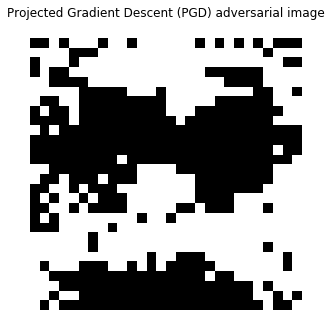

In [123]:
cols   = 1
images_art = list(x_art_adv[:cols])
adv_image_art = images_art[0]

fig    = plt.figure(figsize=(7, 5))

fig.add_subplot(1,1,1)
plt.title("Projected Gradient Descent (PGD) adversarial image\n")
plt.imshow(adv_image_art, cmap='gray')
plt.axis('off')

plt.show()

# Targeted adversarial attack

In [145]:
target_label = 5

In [146]:
# Set the configuration to a targeted attack:
adv.set_params(targeted=True)

x_art_adv_targeted = adv.generate(np.expand_dims(x_test[0],axis=0), y=to_categorical([target_label],10))

In [147]:
prediction = classifier.predict(x_art_adv_targeted)
print("Classified as : ", np.argmax(prediction, axis=1)[0])

Classified as :  5


#### Answer for 1(c) point i :

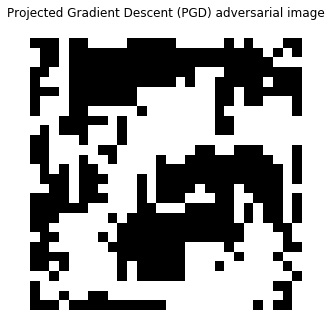

In [148]:
cols   = 1
images_art_targeted = list(x_art_adv_targeted[:cols])
adv_image_art_targeted = images_art_targeted[0]

fig    = plt.figure(figsize=(7, 5))

fig.add_subplot(1,1,1)
plt.title("Projected Gradient Descent (PGD) adversarial image\n")
plt.imshow(adv_image_art_targeted, cmap='gray')
plt.axis('off')

plt.show()

# Analysis

#### Answer for 1(c) point ii :

In [149]:
print("Norms for untargeted attack :\n")

ext_cw = x_test[0] - adv_image_art 

L0_dist = (sum(sum(ext_cw != 0))) / np.size(ext_cw)
print("Frobenius norm (L0)    : {:4.2f}%".format(L0_dist * 100))

L2_dist = LA.norm(ext_cw)
print("Frobenius norm (L2)    : ", L2_dist)

L_inf_dist = LA.norm(ext_cw, np.inf)
print("Frobenius norm (L_inf) : ", L_inf_dist)

Norms for untargeted attack :

Frobenius norm (L0)    : 60.71%
Frobenius norm (L2)    :  20.34381260395647
Frobenius norm (L_inf) :  24.200000000000003


In [150]:
print("Norms for targeted attack :\n")

ext_cw = x_test[0] - adv_image_art_targeted

L0_dist = (sum(sum(ext_cw != 0))) / np.size(ext_cw)
print("Frobenius norm (L0)    : {:4.2f}%".format(L0_dist * 100))

L2_dist = LA.norm(ext_cw)
print("Frobenius norm (L2)    : ", L2_dist)

L_inf_dist = LA.norm(ext_cw, np.inf)
print("Frobenius norm (L_inf) : ", L_inf_dist)

Norms for targeted attack :

Frobenius norm (L0)    : 56.89%
Frobenius norm (L2)    :  19.338373045559234
Frobenius norm (L_inf) :  22.905882352941177
